In [37]:
import pandas as pd
import ast
from tqdm.notebook import tqdm
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import math
from collections import Counter
from scipy.spatial import distance
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('data/df_replies.pickle', 'rb') as f:
    df_replies = pickle.load(f)
df_replies

,conversation_id,user_id,username,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,reply_to,cleaned_tweet,embeddings
0,1193730372,15820442,tomwhild,@stephenfry amen Stephen! Vaccination is so im...,['stephenfry'],0,0,0,[],"[{'user_id': '15820442', 'username': 'tomwhild...",amen stephen vaccination is so important i hat...,"[-0.0054706745, 0.09844217, 0.075048484, 0.013..."
1,1193730372,2276201,sevitz,http://tinyurl.com/btokam Vaccination scares a...,['stephenfry'],0,0,0,[],"[{'user_id': '2276201', 'username': 'sevitz'},...",vaccination scares are so bloody irresponsible...,"[0.04750795, 0.03788834, 0.0015141966, 0.04019..."
2,1193730372,12488312,elbisivni,this chap needs our support http://tinyurl.co...,['stephenfry'],0,0,0,[],"[{'user_id': '12488312', 'username': 'elbisivn...",this chap needs our support vaccination scares...,"[-0.0070269336, 0.043089196, 0.014950992, -0.0..."
3,1193730372,7461972,atariageguy,"@stephenfry Yes, this is infuriating. Especia...",['stephenfry'],0,0,0,[],"[{'user_id': '7461972', 'username': 'atariageg...",yes this is infuriating especially now that we...,"[-0.022819221, 0.02312067, 0.025248187, -0.012..."
4,1193730372,15022458,weaselbacon,@stephenfry Thanks for that. Vaccination is on...,['stephenfry'],0,0,0,[],"[{'user_id': '15022458', 'username': 'weaselba...",thanks for that vaccination is one of my pet i...,"[-0.014918114, 0.041756548, 0.0010046107, -9.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1351123,964000000000000000,766000000000000000,pancaraccia,Le virus de la variole se transmet exclusiveme...,['malacella2b'],0,0,0,[],"[{'user_id': '765943276377628673', 'username':...",le virus de la variole se transmet exclusiveme...,"[0.03683498, 0.06865424, -0.013673961, -0.0267..."
1351124,941000000000000000,849805975,realchaim_rubin,. Calling it mutilation is not convincing Just...,"['rockerman_198', 'huiecaleb', 'peppi1207', 'r...",5,0,0,[],"[{'user_id': '849805975', 'username': 'realCha...",calling it mutilation is not convincing just m...,"[-0.0052796206, 0.015638433, 0.009222518, -0.0..."
1351125,961000000000000000,743000000000000000,suraiyahuss,In 1796 the English doctor Edward Jenner devel...,"['zuk60', 'hamedomaribrah3', 'saranoo14119598'...",1,0,2,[],"[{'user_id': '742765890735869954', 'username':...",in the english doctor edward jenner develops t...,"[0.007919503, 0.08331335, 0.031874426, -0.0441..."
1351126,941000000000000000,976000000000000000,dkingpower7,No. Circumcision is nothing like vaccination. ...,"['realchaim_rubin', 'genintact', 'scriptelador...",0,0,0,[],"[{'user_id': '976478598117851136', 'username':...",no circumcision is nothing like vaccination on...,"[0.07487217, 0.09335318, -0.043020695, 0.03961..."


In [43]:
replies = {}
for i in tqdm(df_replies.index):
    user_id = df_replies.loc[i, 'user_id']
    user_replies = df_replies.loc[i, 'reply_to']
    for user_reply in user_replies:
        user_reply_id = int(user_reply['user_id'])
        if user_id in replies:
            if user_reply_id in replies[user_id]:
                replies[user_id][user_reply_id]['weight'] += 1
            else:
                replies[user_id][user_reply_id] = {'weight': 1}
        else:
            replies[user_id] = {}
            replies[user_id][user_reply_id] = {'weight': 1}

strong_replies = []

for key in tqdm(replies):
    for node in replies[key]:
        weight = replies[key][node]['weight']
        if weight >= 3:
            strong_replies.append([key, node, weight])

strong_replies = pd.DataFrame(strong_replies, columns=['source', 'target', 'weight'])
replies_graph = nx.from_pandas_edgelist(strong_replies,
                                        source='source',
                                        target='target',
                                        edge_attr='weight',
                                        create_using=nx.DiGraph)

strong_replies

  0%|          | 0/1351128 [00:00<?, ?it/s]

  0%|          | 0/465344 [00:00<?, ?it/s]

,source,target,weight
0,12488312,12488312,3
1,666703,666703,3
2,29281472,29281472,3
3,18093751,18093751,3
4,19471256,19471256,12
...,...,...,...
97785,1130000000000000000,1438942627,3
97786,2189944839,2189944839,6
97787,2189944839,3655550867,6
97788,2189944839,934847661567561728,6


In [31]:
nx.write_gexf(replies_graph, 'replies_graph_3.gexf')

In [27]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=True)

positions_replies_graph = forceatlas2.forceatlas2_networkx_layout(replies_graph, pos=None, iterations=1000)

100%|██████████| 1000/1000 [05:39<00:00,  2.94it/s]

BarnesHut Approximation  took  142.06  seconds
Repulsion forces  took  187.48  seconds
Gravitational forces  took  0.99  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  4.18  seconds


In [20]:
with open('replies_graph.pickle', 'wb') as f:
    pickle.dump(positions_replies_graph, f)

In [24]:
with open('replies_graph_1.pickle', 'wb') as f:
    pickle.dump(positions_replies_graph, f)

In [3]:
reply_clusters = pd.read_csv('data/63k_graph_clusters.csv')
replies_edges = pd.read_csv('data/63k_graph_edges.csv')

In [7]:
reply_clusters

,Id,Label,modularity_class,clustering,X,Y
0,19471256,19471256,0,0.000000,6459.395508,954.955811
1,22371039,22371039,1,0.000000,-1725.032471,6716.541016
2,131188226,131188226,2,0.000000,-1005.163696,4615.148926
3,14270356,14270356,3,0.000000,-3429.591064,-2476.263184
4,112724522,112724522,847,0.050725,1306.691772,-847.132690
...,...,...,...,...,...,...
57035,881218243,881218243,47937,0.000000,-2401.455566,973.516113
57036,950464698880876544,950464698880876544,47937,0.000000,-2390.913086,886.267395
57037,986041419067408385,986041419067408385,47937,0.000000,-2605.056152,870.444824
57038,2189944839,2189944839,4343,0.250000,862.475220,-2205.425293


In [14]:
replies_edges

,Source,Target,Type,Id,Label,Weight
0,19471256,19471256,Directed,0,NaN,12
1,22371039,22371039,Directed,1,NaN,4
2,131188226,131188226,Directed,2,NaN,13
3,14270356,14270356,Directed,3,NaN,102
4,112724522,112724522,Directed,4,NaN,5615
...,...,...,...,...,...,...
63505,547733239,115188876,Directed,63505,NaN,4
63506,2189944839,2189944839,Directed,63506,NaN,6
63507,2189944839,3655550867,Directed,63507,NaN,6
63508,2189944839,934847661567561728,Directed,63508,NaN,6


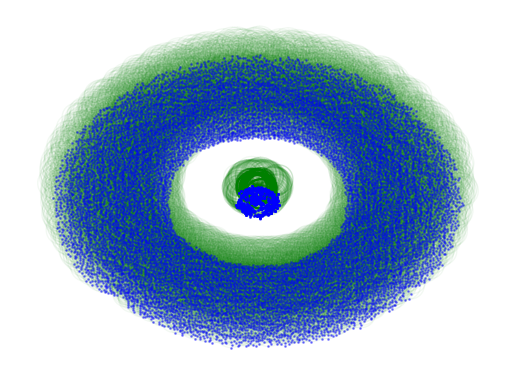

In [28]:
nx.draw_networkx_nodes(replies_graph, positions_replies_graph, node_size=1, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(replies_graph, positions_replies_graph, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [8]:
reply_clusters['modularity_class'].value_counts()

299      702
8053     606
20385    552
300      492
4343     464
        ... 
16140      1
16141      1
16142      1
16143      1
23926      1
Name: modularity_class, Length: 47938, dtype: int64

In [10]:
reply_clusters.sort_values(by='clustering')

,Id,Label,modularity_class,clustering,X,Y
0,19471256,19471256,0,0.0,6459.395508,954.955811
37237,108457870,108457870,33153,0.0,318.686340,-3734.054199
37238,2376705296,2376705296,33154,0.0,1954.811523,-4924.671875
37239,568167318,568167318,33155,0.0,4130.889160,1385.781006
37241,2428930292,2428930292,33156,0.0,6437.939941,-5272.679688
...,...,...,...,...,...,...
31299,52950375,52950375,4343,1.0,-821.834656,-1224.046509
18083,3266311586,3266311586,4343,1.0,-657.839722,-1783.696411
31301,15911378,15911378,4343,1.0,-775.326294,-1231.887451
3370,300701238,300701238,12628,1.0,-691.496948,835.247864


In [11]:
reply_clusters.query('modularity_class == 299')

,Id,Label,modularity_class,clustering,X,Y
556,351231520,351231520,299,0.300000,1943.717163,-255.382217
582,776638213,776638213,299,0.125000,1874.201782,-113.801643
655,205670342,205670342,299,0.079051,1968.718872,-29.745789
656,10228272,10228272,299,0.000030,1959.189575,19.838783
739,228769235,228769235,299,0.152778,2075.383789,23.619255
...,...,...,...,...,...,...
56952,254909054,254909054,299,0.500000,1950.435791,-118.735771
56979,47074030,47074030,299,0.200000,1314.802979,592.704956
56980,860402118,860402118,299,0.000000,1274.730347,754.968384
56981,73345842,73345842,299,0.000000,1294.950439,635.341064


In [27]:
import random
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
get_colors(3)

['#2681bc', '#fa32b6', '#84b4ff']

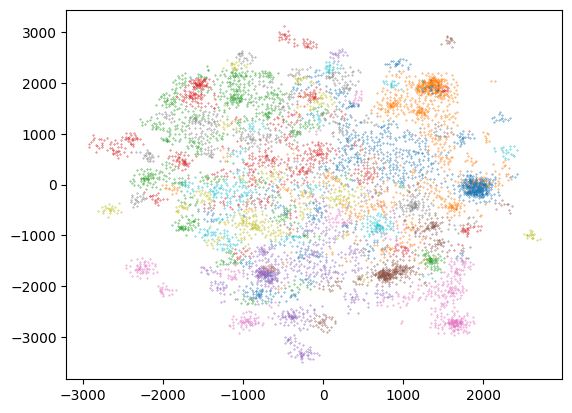

In [35]:
most_modularity = list(reply_clusters['modularity_class'].value_counts().index)[:50]
dotes = reply_clusters.query('modularity_class in @most_modularity')

for modul in most_modularity:
    modul_dotes = dotes.query('modularity_class == @modul')
    plt.scatter(modul_dotes['X'], modul_dotes['Y'], s=0.1)

In [4]:
graph_statistics = pd.read_csv('data/63k_graph_all_statistics.csv')
graph_statistics

,Id,Label,modularity_class,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,stat_inf_class,clustering,componentnumber,strongcompnum,indegree,outdegree,degree,pageranks,eigencentrality,X,Y,Size,Color
0,19471256,19471256,0,0,0.000000,0.000000,0.00,0,0.000000,0,0,1,1,2,0.000003,0.000543,4474.727051,5673.375000,10,#000000
1,22371039,22371039,1,0,0.000000,0.000000,0.00,1,0.000000,1,1,1,1,2,0.000003,0.000543,7253.721191,275.154907,10,#000000
2,131188226,131188226,2,0,0.000000,0.000000,0.00,2,0.000000,2,2,1,1,2,0.000003,0.000543,7865.322754,-5738.039551,10,#000000
3,14270356,14270356,3,0,0.000000,0.000000,0.00,3,0.000000,3,3,1,1,2,0.000003,0.000543,5429.376953,6731.066406,10,#000000
4,112724522,112724522,848,2,0.758621,0.840909,5364.45,37564,0.050725,4,26,9,16,25,0.000011,0.038338,613.029541,-157.643845,10,#000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57035,881218243,881218243,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,56769,1,0,1,0.000003,0.000543,1881.251343,-1593.412109,10,#000000
57036,950464698880876544,950464698880876544,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,56768,1,0,1,0.000003,0.000543,1864.592896,-1634.596069,10,#000000
57037,986041419067408385,986041419067408385,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,56767,1,0,1,0.000003,0.000543,1924.354004,-1594.196533,10,#000000
57038,2189944839,2189944839,4341,2,0.800000,0.875000,0.00,37564,0.250000,4,56790,1,4,5,0.000003,0.000543,-1740.692627,563.545959,10,#000000


In [9]:
graph_statistics['modularity_class'].value_counts()[:50]

/var/folders/mg/cn2grfyj1s744mx1p527fzgm0000gn/T/ipykernel_7394/814670878.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  graph_statistics['modularity_class'].value_counts()[:50]


301      681
8043     579
12827    512
11265    496
4341     402
848      327
13788    301
22212    299
12614    242
56       232
45617    205
633      200
3456     166
300      162
47762    145
13028    117
27413    113
45770    104
13208    101
4652     100
14204     89
6093      79
46713     73
4342      65
783       65
4749      62
4729      60
4963      53
3761      53
46827     53
3706      52
10949     51
44343     49
45641     49
44338     46
46370     40
45860     36
47463     34
46918     26
44274     25
18874     24
44244     23
45949     22
45902     20
35631     20
44267     20
31177     20
47024     19
47610     19
44248     18
Name: modularity_class, dtype: int64

In [14]:
dotes = graph_statistics.query('modularity_class in @most_modularity')
cluster_dotes = np.array([[x, y] for x, y in zip(dotes['X'], dotes['Y'])])

In [97]:
dotes

,Id,Label,modularity_class,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,stat_inf_class,clustering,componentnumber,...,indegree,outdegree,degree,pageranks,eigencentrality,X,Y,Size,Color,cluster
4,112724522,112724522,848,2,0.758621,0.840909,5364.45,37564,0.050725,4,...,9,16,25,0.000011,0.038338,613.029541,-157.643845,10,#000000,2
5,16426177,16426177,848,0,0.000000,0.000000,0.00,37564,0.500000,4,...,2,1,3,0.000004,0.009842,614.886047,-158.641068,10,#000000,2
6,262724663,262724663,848,0,0.000000,0.000000,0.00,37564,0.500000,4,...,3,1,4,0.000004,0.010677,593.963867,-292.862122,10,#000000,2
7,22931893,22931893,848,0,0.000000,0.000000,0.00,37564,0.333333,4,...,4,1,5,0.000004,0.045608,634.482971,-81.524704,10,#000000,2
8,34115195,34115195,8043,0,0.000000,0.000000,0.00,37564,0.089286,4,...,8,0,8,0.000009,0.097574,277.517944,2074.891602,10,#000000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57035,881218243,881218243,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,...,1,0,1,0.000003,0.000543,1881.251343,-1593.412109,10,#000000,29
57036,950464698880876544,950464698880876544,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,...,1,0,1,0.000003,0.000543,1864.592896,-1634.596069,10,#000000,29
57037,986041419067408385,986041419067408385,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,...,1,0,1,0.000003,0.000543,1924.354004,-1594.196533,10,#000000,29
57038,2189944839,2189944839,4341,2,0.800000,0.875000,0.00,37564,0.250000,4,...,1,4,5,0.000003,0.000543,-1740.692627,563.545959,10,#000000,8


In [106]:
replies_statistics = df_replies.merge(dotes, left_on='user_id', right_on='Id', how='left')

with open('replies_statistics.pickle', 'wb') as f:
    pickle.dump(replies_statistics, f)

In [107]:
replies_statistics

,conversation_id,user_id,username,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,reply_to,...,indegree,outdegree,degree,pageranks,eigencentrality,X,Y,Size,Color,cluster
0,1193730372,15820442,tomwhild,@stephenfry amen Stephen! Vaccination is so im...,['stephenfry'],0,0,0,[],"[{'user_id': '15820442', 'username': 'tomwhild...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1193730372,2276201,sevitz,http://tinyurl.com/btokam Vaccination scares a...,['stephenfry'],0,0,0,[],"[{'user_id': '2276201', 'username': 'sevitz'},...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1193730372,12488312,elbisivni,this chap needs our support http://tinyurl.co...,['stephenfry'],0,0,0,[],"[{'user_id': '12488312', 'username': 'elbisivn...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1193730372,7461972,atariageguy,"@stephenfry Yes, this is infuriating. Especia...",['stephenfry'],0,0,0,[],"[{'user_id': '7461972', 'username': 'atariageg...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1193730372,15022458,weaselbacon,@stephenfry Thanks for that. Vaccination is on...,['stephenfry'],0,0,0,[],"[{'user_id': '15022458', 'username': 'weaselba...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351123,964000000000000000,766000000000000000,pancaraccia,Le virus de la variole se transmet exclusiveme...,['malacella2b'],0,0,0,[],"[{'user_id': '765943276377628673', 'username':...",...,0.0,19.0,19.0,0.000003,0.000000,1825.054443,-1056.008911,10.0,#000000,29.0
1351124,941000000000000000,849805975,realchaim_rubin,. Calling it mutilation is not convincing Just...,"['rockerman_198', 'huiecaleb', 'peppi1207', 'r...",5,0,0,[],"[{'user_id': '849805975', 'username': 'realCha...",...,1.0,53.0,54.0,0.000003,0.000543,1915.292847,-2043.280762,10.0,#000000,41.0
1351125,961000000000000000,743000000000000000,suraiyahuss,In 1796 the English doctor Edward Jenner devel...,"['zuk60', 'hamedomaribrah3', 'saranoo14119598'...",1,0,2,[],"[{'user_id': '742765890735869954', 'username':...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1351126,941000000000000000,976000000000000000,dkingpower7,No. Circumcision is nothing like vaccination. ...,"['realchaim_rubin', 'genintact', 'scriptelador...",0,0,0,[],"[{'user_id': '976478598117851136', 'username':...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


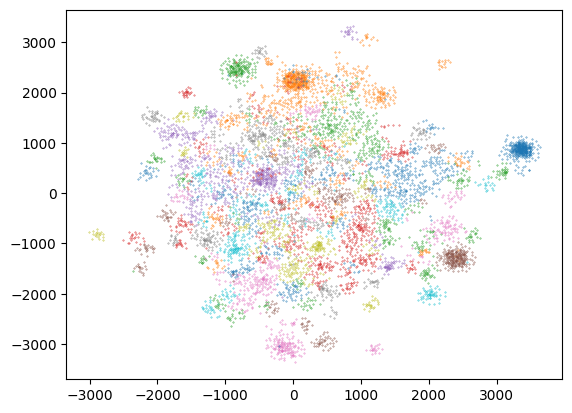

In [11]:
most_modularity = list(graph_statistics['modularity_class'].value_counts().index)[:50]

for modul in most_modularity:
    modul_dotes = dotes.query('modularity_class == @modul')
    plt.scatter(modul_dotes['X'], modul_dotes['Y'], s=0.1)

In [48]:
cluster_model = AgglomerativeClustering(n_clusters=50).fit(cluster_dotes)
dotes['cluster'] = cluster_model.labels_

Cluster 1



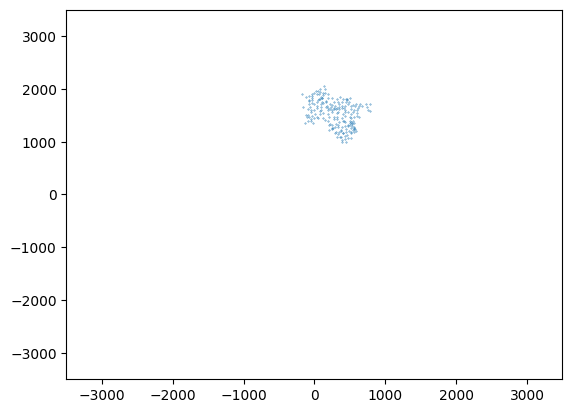

has been adressing anti vaccination myths for the last few weeks latest vaxfax
visit my blog if you would like to chat about science and the media and the anti vaccination movement
ecdc comments on acceptability of hpv vaccination among young adults a population based survey in sweden
interested about vaccination programmes and their new challenges in europe see ecdc directors speech ecdc
what s european immunization week and how can u participate publichealth globalhealth vaccination measles flu
lw discussion on optimizing adult vaccination for healthier working populations in europe ehfg
efficacy of polio vaccination initiative in children paralyzed in cases so far
off to speak to tower hamlets gps about vaccination at mile end hospital vaxfax vaccine
aus should adopt no fault compensation for accidental damage caused by vaccination argues david isaacs of
pro ah bovine tuberculosis uk badger vaccination
a key to polio control in india is vaccination of migrants these migrants have al

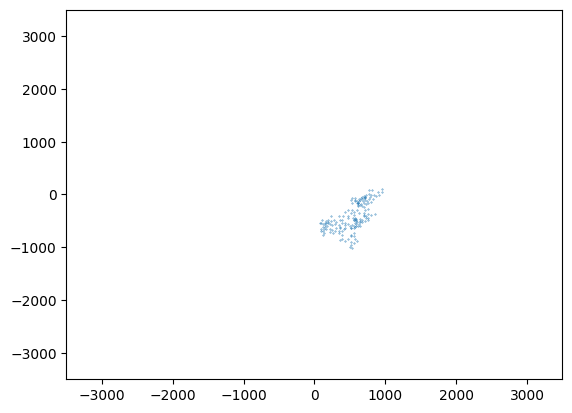

a customized vaccination plan has just been created for s
bachmann perry and the hpv at first it seems surprising that a vaccination is central to
thanks com for this post on vax vaccination indy film
looking for data on vaccination rates in europe post lancet mmr paper have good info already for uk vaccines vaxfax
association between medicaid reimbursement and child influenza vaccination rates
flu vaccination protects the employees those they live work with healthcare workers can protect patients too
and more died each year from the vaccination dax did you watch all the sb hearings have you watched traceamounts
the greater good weaves together the stories of families whose lives have been forever changed by vaccination
the rationale behind current worldwide human papilloma virus hpv vaccination programs starts from two basic
there can be no doubt that parents must be able to make their own free and informed vaccination choices for their children boyd haley phd
seasonal influenza and h

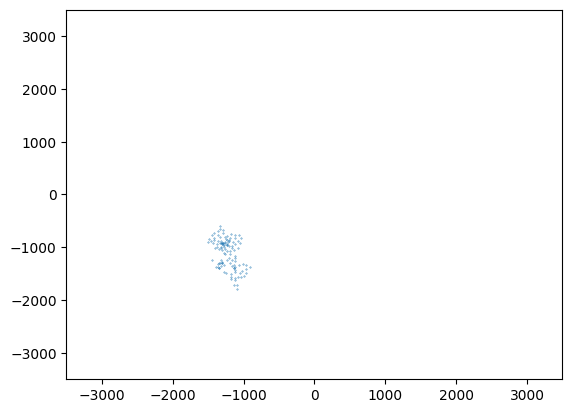

with proper planning selective rather than mass vaccination can provide immunity against flu say physicists w
nine month old twins die just minutes after measles vaccination via
with proper planning selective rather than mass vaccination can reduce spread of flu say physicists via
novartis says fda approves menveo vaccination in children not infants bloomberg
a cont it isn t likely that mmr or any other childhood vaccination plays a meaningful role in the increased prevalence in autism sinoff
vaccination vaccine scientist who downplayed links to autism indicted by doj in alleged fraud scheme via
poll which city should we dedicate our vaccination awareness efforts towards hcsm
mt publichealth needs btter marketing vaccination awareness by w hcsmvac
some pediatricians are taking a stand by refusing to treat children whose parents refuse to immunize them vaccination
woman questions grandson s hpv vaccination
m in humanitarian funding for nationwide polio vaccination in syria
us only cdc r

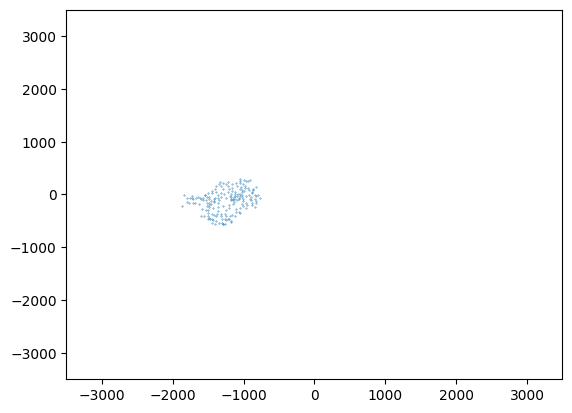

chief doctor writes to queensland parents urging measles vaccination
nine month old twins die just minutes after measles vaccination
are you sure it s not the h n pandemrix vaccination shot you just got
listen everyone that omg vaccination junkie pic is satire
mmr vaccination urged as confirmed cases of measles soar in england and wales c news
kids dying after suffering a fatal reaction to vaccination is a bit like not having kids isn t it
mandatory vaccination goes against human rights do your research on vaccines
this weeks podcast a new antibiotic for c difficile low back pain and vaccination for hpv in males
the vaccination autism connection does not exist learn the truth about vaccine autism myths from
before vaccination measles killed couple of million people a year still k kids dying each yr from it
were death rates not supposed to continue their massive decline after vaccination
cdc reports spike in us measles cases in a plos blog lays out societal costs of declining vaccinatio

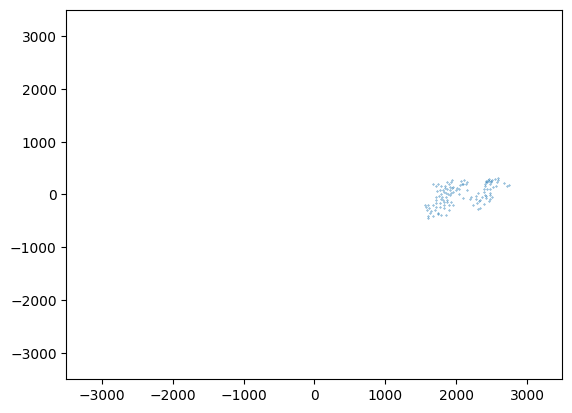

vaccination in hypogammaglobulinemia
with proper planning selective rather than mass vaccination can provide immunity against flu
guarda questo video teen paralyzed after getting h n vaccination via
doh region over k children to receive measles rubella vaccination
measles outbreak blamed on poor implementation of vaccination program
good afternoon i sent an fb message po w questions re the doh s dengue vaccination program hoping for your response po
les franais boudent la vaccination alors que la rougeole menace
krono can consume half a bottle of goats milk every feeding toxic din ang vaccination schedule parang mas complete pa ata bakuna nya ah
dr jayne donegan vaccination the question september sunday london nw
ubial we got coverage on the st batch of dengue vaccination and we got less than coverage of the second batch of vaccination
parents warned against new vaccination guidelines via
vaccination a very personal decision are you informed via
the sudden death of your child after vac

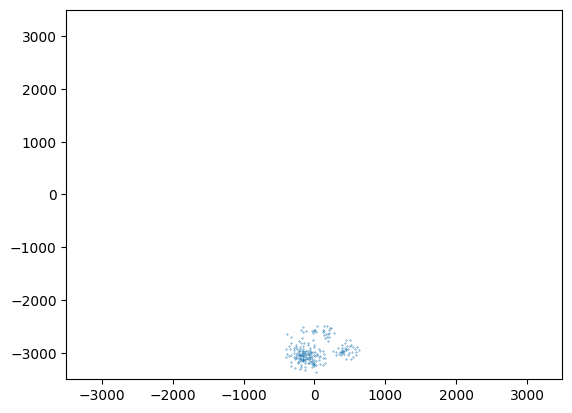

why is there a witch hunt on species is it badger first move onto others vaccination has to be the answer
but vaccination was only licenced in march of this year so largely untested
para e may answer vaccination r d generally needs more and political will ok btb is important to us but malaria
a positive approach that more should try stopthecull bbc news badgers given tb vaccination in shropshire and cheshire
impact of badger vaccination on bovine tb in the iaa of wales will be measurable after years very unlikely
this is never going to end is it now farmers in wales vaccination area want licences to cull badgers sigh
back to wales now badger vaccination meeting v interesting
vaccination update at
indeed the primary reason for abandoning vaccination in wales is the lack of investment in producing bcg
trust planning badger vaccination
better get ready to defend badgers against free range shooting instead of vaccination bovinetb harms no one cull pointless
badgers kill or cure check out o

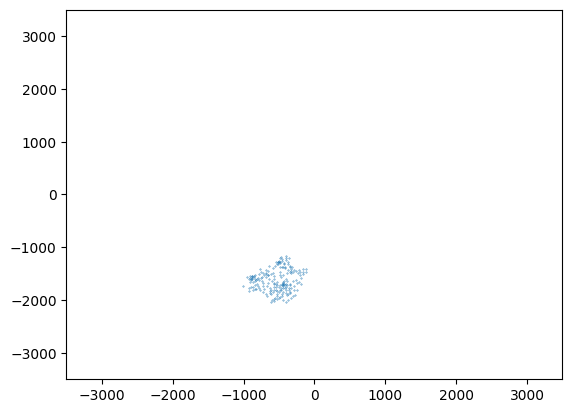

conditions of application to control badgers include overall plan including vaccination
great article brian really puts to bed the claims from nfu and gov concerning eu obstacles to cattle vaccination for tb
eye catching data published today on benefits of tb badger vaccination and how it could be deployed alongside culling
nsa on this weeks operation silver birch simulated fmd outbreak preparations are good vaccination remains a challenge
check out our website offering an efficient service of badger vaccination to landowners across the uk
antibody pos badgers are late in infection likely to shed m bovis in urine etc so vaccination seemed to reduce these a good thing
i want tb free cattle and badgers vaccination is the only way
im a student with a passion for btb ive emailed samuel co uk x about vaccination meeting but no reply is the email correct please
ploscompbio new paper published today on the challenges of using cattle vaccination as a control for btb
also my original reply was 

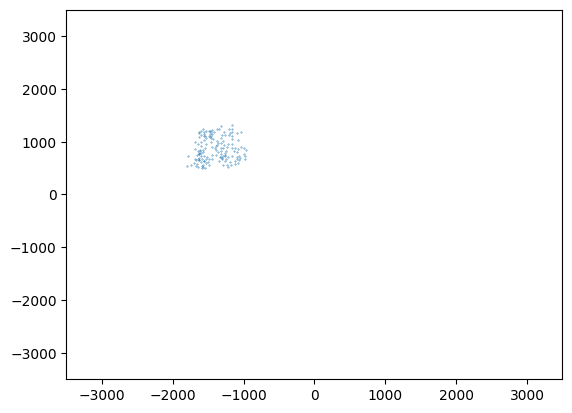

no time limit generally the only time a vaccination is not given us when someone has a fever infection let me research a bit
nurses have you seen this doh issues letter on importance of flu vaccination for nurses mws via
pregnant women should protect themselves from seasonal flu and swine flu by getting the seasonal flu vaccination
nhs flu fighter we want to spread the word about the seasonal flu vaccination and increase the uptake among nhs staff
have you attended your cervical screening appointment or had your hpv vaccination if you have youre an s girl
european vaccine manufacturers evm launch online platform for discussing vaccines and vaccination
plans for a staff seasonal flu vaccination campaign are underway we want to hear your ideas on how to increase uptake
sorry but steve scrutton is making a statement which is contrary to the available evidence vaccination is safe
of cases of pertussis was in people who were vaccinated does vaccination even work doesn t seem so
different va

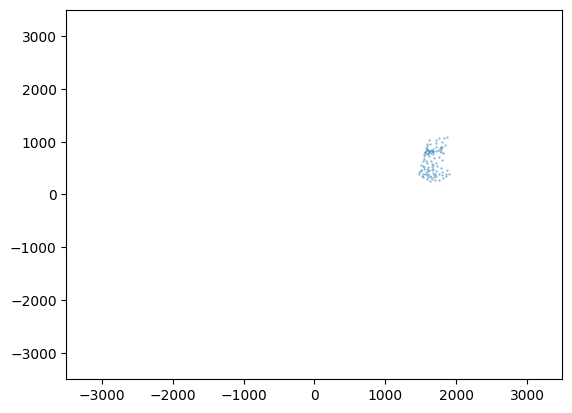

une japonaise est morte d un choc anaphylactique la suite de la vaccination mais demain je me fais vacciner contre la grippe
punjab pneumococcal vaccination soon
vaccination of stray dogs begins in tirupur
news clerics in policy flip flop over polio vaccination pakistan
central africa mass polio vaccination drive set to begin
cte d ivoire chaos blocks yellow fever vaccination drive
looking back and moving forward years of pneumococcal vaccination since the introduction of smallpox vacc
blog students from afghanistan organize polio fundraiser and community vaccination campaign
afghanistan gov t boosts vaccination coverage after jump in disease outbreaks v
paho to discuss cholera vaccination in the americas haiti cholera
mobile teams embark upon door to door vaccination in karachi
innovative project helps children in india map community identify needs and support polio and vaccination campaigns
polio vaccination campaign ends successfully in somaliland
fake yellow fever vaccination certi

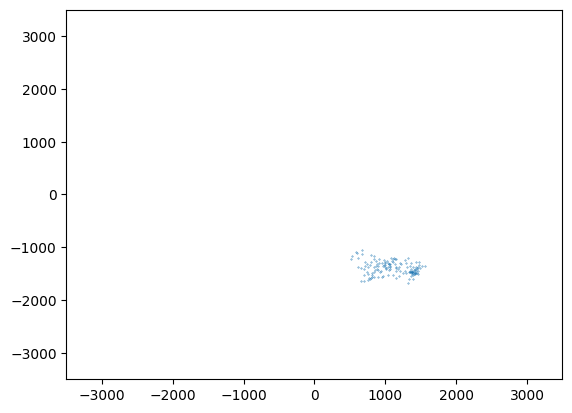

then look up how the cdc who distributed the aids virus via vaccination to millions of africans in the s
great update from my dad amazing progress in honduras where vaccination rates exceed wealthy countries vaccineswork
pandemrix aucune preuve ne permettrait d tablir un lien entre narcolepsie et vaccination pharma h n
the ways that they plan to depopulate is my mass vaccination like the we had last year with h n it was order by the who
nouvelle campagne pour encourager la vaccination
the mmr vaccination autism link was based on completely bogus and fraudulent science educate yourself before putting others lives at risk
scientists demonstrate injection free vaccination technique medindia
suis all faire mon eme contrle de vaccination hpatite b le er tube s tant perdu elle m a rat callvirenque
enqute de sant la vaccination en questions demain h sur allodocteurs
chiens errants d ukraine et la vaccination contre la rage
beimmunized makes shot records digital increases vaccination more abou

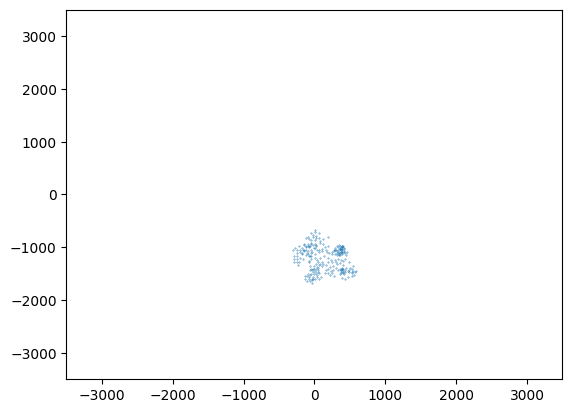

a masterpiece of selective reporting ignorance and dangerous bs coerced vaccination unacceptable
avis vaccination contre la grippe saisonnire par le vaccin intanza g
oh noooooon bonne ide de me rappeler de prendre mon carnet de vaccination mais y a rien dessus ausecours
doctor say vaccination rates among teens are still too low we aren t trying as hard as we could
suite une demande la vaccination pour les nuls ror vaccins aluminium adjuvants
vaccination anti grippale risquer un syndrome de guillain barr afin dviter un arrt de travail
en pratique le communiqu confirme l absence totale de donnes chez les personnes ges cibles par la vaccination
la campagne de vaccination contre la grippe est prolonge de jours
un grand dbat citoyen et participatif sur la vaccination sera organis cette anne cest la condition de ladhsion des franais
grard bapt demande la tenue d une tude mdico conomique avant d envisager la vaccination anti hpv l cole
le japon signale la mort d un sixime enfant aprs une vacc

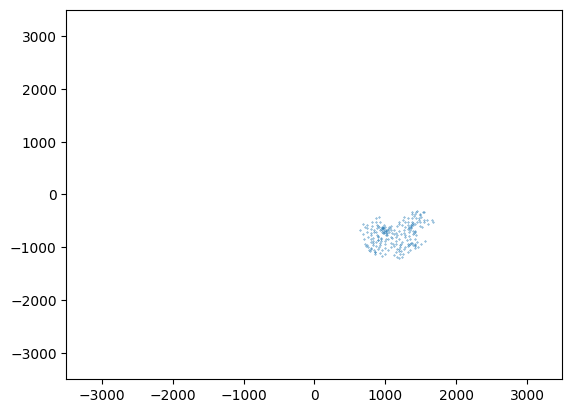

dangers of vaccination
attorney at law e book authoritative guide to vaccination maze exemptions waivers your rights in the u s
frquence vaccination
la vaccination est grippe vaccin grippe
clinic for parents who oppose vaccination opening in california barbaraloefisher
grippe l pidmie arrive mais la vaccination tarde
homeopathic treatment of vaccination syndrome medicine health homeopathy homeopaths herbal pharmacy
mmr vaccination compensation hwc science vaccines camunited we care
the poisoned needle suppressed facts about vaccination eleanor mcbean
nc school district to give away ipod laptop to children who participate in vaccination contest via
study finds higher rate of autism in us also higher rate of vaccination
cases of autism dwarf risk from measles homeopathy vaccination camunited autismrisk
using the power of song to question vaccination check out the refusers
new article second vaccination clinic tomorrow
cia organised fake vaccination drive to get osama bin laden s family d

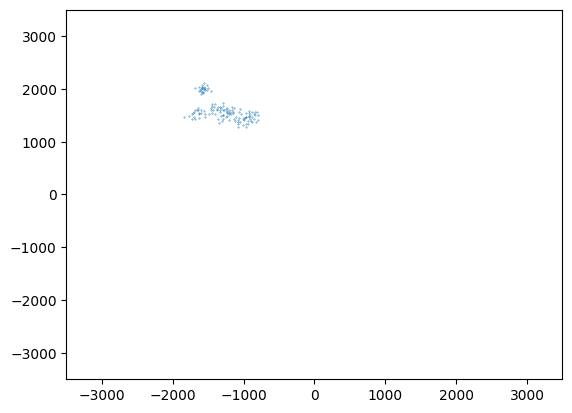

cdc national and state vaccination coverage among adolescents aged years childrenshealth
under new law school nurses aim to stop rise in vaccination opt outs by immunizations
school districts get day extension on whooping cough vaccination requirement for th graders with sb
nicholas d smith responds to a difficult question about child vaccination against the wishes of a caregiver
cdphe healthteamworks create tool kit for health care professionals re flu vaccination during pregnancy influenza
brighton woman was worried about mmr after hearing about wakefield realises she was wrong and calls for vaccination
unicef using african refugee crisis to target kenyan children for vaccination learn more
mt cost of cia sponsored fake vaccination effort to get bin laden polio eradication
if homeopaths recategorise vaccination as homeopathy they at least get to say that homeopathy works because vaccination does
la vaccination contre la grippe a a sauv des gens p berche
mt pregnant women to be offere

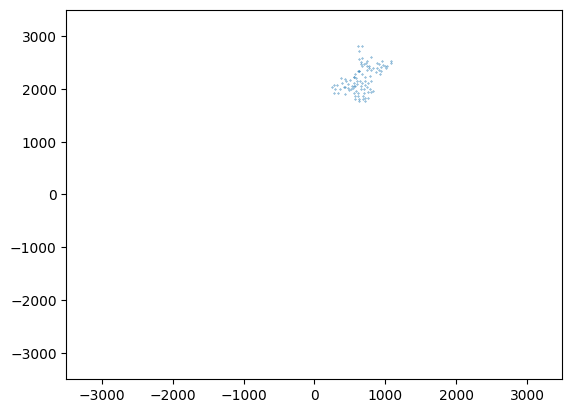

mandatory vs compulsory vaccination when parents force the governments hand on vaccines via
anti vaccination group forced to change name
wonder why raw milk anti vaccination believers think it s acceptable to send messages threatening a reporter to your grave and beyond fu
vaccination rates falling for children with health insurance when it comes to the subject of vaccines and autis
la vaccination contre la grippe va bon train jean pascal lavoie sant via non merci je tue la grippe
holier than thou bill gates register every birth by cellph ensure vaccination control population growth via
eurovaccine european vaccination conference via
millions of chinese oppose mass vaccination plan infowars ireland via
pharmacy fends off rcgp attack on flu vaccination service updated pj online via
la une vaccination par les pharmaciens une entente est possible dit bolduc
in pictures pneumonia vaccination in nairobi
detailed plan on how to prevent and treat all flus infections without vaccination antibi

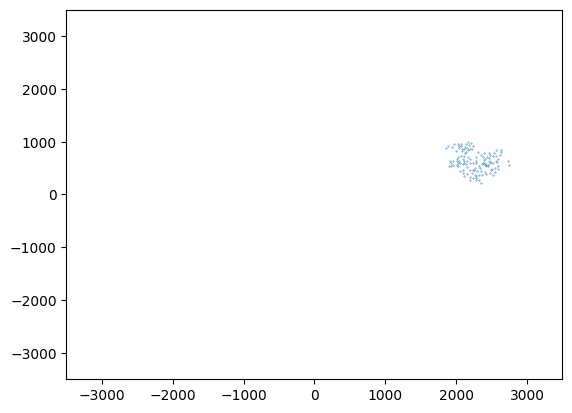

you ve avoided my question about vaccination climate change
seasonal influenza vaccination cuts stillbirth risk by half
tetanus diphtheria and pertussis tdap vaccination every years is unnecessary a new cross sectional analysi
countrywide vaccination of dogs and cats launched ahead of world veterinary day
there is a funding gap in immunization and vaccination we must keep advocating to fill this gap avwng nigeriaimmunize
bringing awareness among folks about vaccination chemistsworld worldimmunizationweek onlineplatform medicine
vaccination caused asthma anaphylactic shock and shingles stopmandatoryvaccination stopforcedvaccination
youngsters s worry of needles anxiety fear fearofneedles vaccination news
if you re pregnant it is recommended that you have the pertussis whooping cough vaccination ask for a nurse appointment to get yours
sugar helps medicine go down takes the sting out of vaccination pain now vaccinations at home also wecare
who to launch emergency yellow fever vaccination

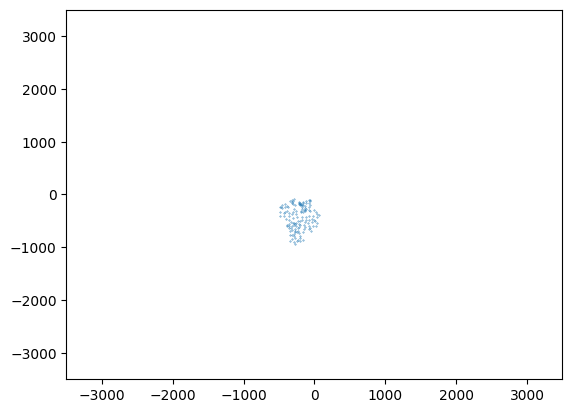

life after the gardasil vaccine many people who experience adverse events after vaccination do not want their
my conversation with andrew wakefield a pioneer in researching the link between vaccination and autism
grippe la campagne de vaccination prolonge jusquau fvrier compte tenu des dernires donnes sur lpid
vaccination contre la grippe vers une politique sanitaire cohrente
naturalnews exclusive international medical council on vaccination refutes vaccine propaganda with myth busting report
sponsored rabies vaccination clinics getting underway around the state protect your pets go to for details
la semaine europenne de la vaccination se tiendra entre le avril et le mai le chu d angers
texas lawmakers spar over so called anti vaccination amendment
lyon sant deux patientes demandent des indemnisations aprs une vaccination
mningite c ne pas oublier la vaccination recommande tous les enfants de an et des adultes jusqu ans
dear rick perry you were in merck s back pocket with mandatory hpv

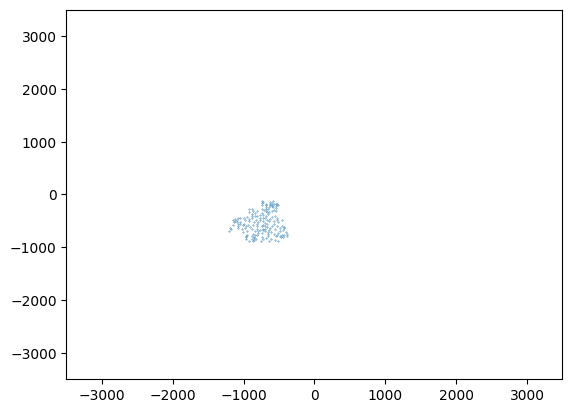

discuss the future of rabies vaccines and the vaccination protocol dr schultz uses with his own pets
fda and cdc gathering more data in the meantime increase in seizures reported following vaccination of children
vital test to perform before cat vaccination via pass on
at my clinic i follow a very minimalistic vaccination protocol which includes titering to insure immunity has been achieved pets
more measles ahead in mn unless vaccination rates rise
in memoriam infant deaths and vaccination via
vaccination the pet controversy
what religions prohibit vaccination
any vaccination can make you feel unwell for a few days suggest you pop to docs
low hpv vaccination rates in sc causing concern
great news new dog vaccination guidelines via
where s the compassion for the victims of vaccination via
is your doctor being bribed to increase vaccination rates via
under obama watch new laws proposed to enforce on general public vaccination trials is this nazism at it s worst stop the rot vote ron pau

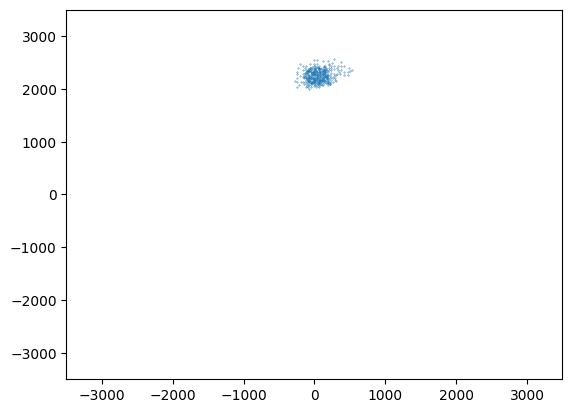

an unvaccinated child almost dies of hib epiglottitis and his parents learn why vaccination is so important
for autism vaccination is the simple answer that is tragically wrong
sharp end of vaccination the daily telegraph bigger ouch stopavn vaxfax sol vaccinetimes
formal quals as chiro read over hrs on vaccination based on content majority of hrs spent on avn mercola etc
ahh yes indeed i normally try to argue both sides of an issue but opposition to vaccination is reprehensible imho
today during a public lecture i was aked about homeopaths advising against vaccination i called this criminal
marvellous dangerous anti vaccination book promoting measles as a good thing to have dumped via
there have been sooooo many studies and drs say results now rule out any link between vaccination and autism
thousands of babies lives saved in mexico due to rotovirus vaccination via
linking autism to vaccination is equivalent to falsely shouting fire in a theatre discuss
six health workers have been sh

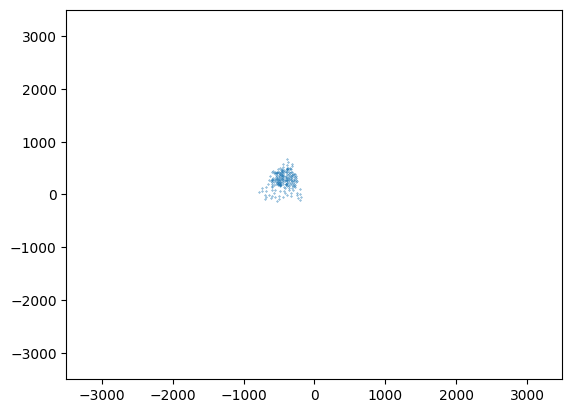

vaccines and the diseases vaccination can cause autism new video on youtube
big brother strikes as daily mail removes all comments about six in one vaccination day
annals of medicine since the testing period employed was too short to evaluate long term benefits of hpv vaccination
ipak has issued a statement on hpv vaccination http
read president obama s proclamation on national influenza vaccination week nivw flu
ditching flu vaccination campaign has put under fives at risk labour is demanding a rethink after the governm
i would recommend the vaccination for all kids with asthma without a doubt
pakistan polio vaccination workers shot dead
i still have the scar on my arm from my vaccination when i was younger hardly visible now the age of technology moves faster
also am journalist writing about vaccination low budget so can t always buy movies want to refer to youtube access was great
obviously there needs to be dilligence in vaccination and hygiene mt pathogenposse indeed
vaccinesnova 

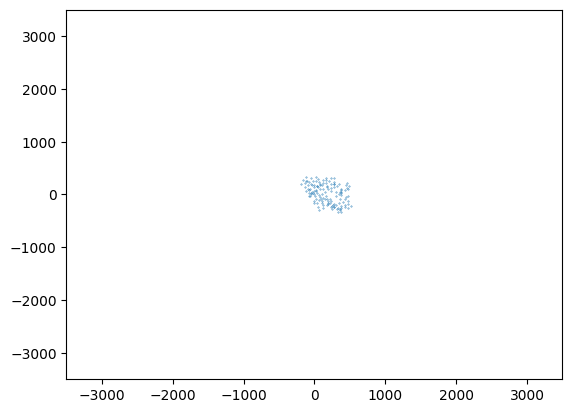

how many of these vaccine vaccination facts do you know
hmmm the cdc declared universal vaccination the goal this year for all americans including infants over months
i took the vaccination pledge you should too the flu ends with u stopavn vaxfax vaccinetimes sol
please consider donating to vaccination news trying to get grant money but it will take time which we are running out of
vaccination is cheaper than treating the illnesses that vaccines prevent vaccinetruth
dr offit the easier it is to get vaccination exemptions in a state the higher the incidence of vax preventable illness death
hepatitis b vaccination and chronic fatigue syndrome cfs novax vaccines
ready to rock the health world today dr buttar joins me for advanced medicine monday radiation vaccination mercury
newborn seized because mom questioned necessity of vaccination
vaccination myths busted with science
la vaccination des enfants linsu des parents deviendra bientt la norme au niveau mondial
info confidentielle de pfiz

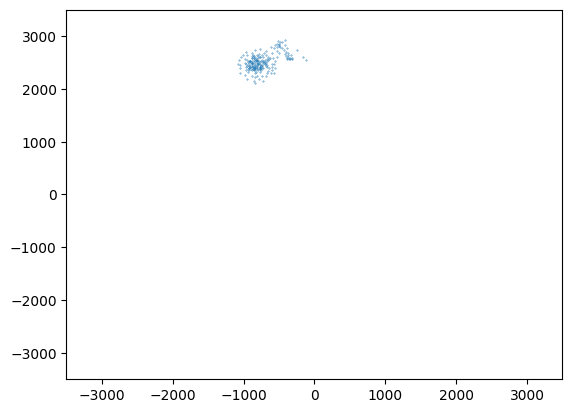

vaccines and the diseases vaccination can prevent via
emergency vaccination campaign against yellow fever outbreak in cote d ivoire globalhealth yellowfever
meningitis vaccination campaign targets million in burkina faso
sudan reports suspected yellow fever outbreak in localities cases deaths vaccination campaign under way
in afghanistan only refusal case has been reported till on polio vaccination
vaccination team is on standby to go to bor if unhas gets the flight safety assurances malakal on hold because of violence there again
press release in english dari pashto statement of the humanitarian coordinator for afghanistan polio vaccination in shahwalikot now crucial campaign to start on monday december download the statement here
polio au congo l onu lance une vaste campagne de vaccination
polio mass vaccination drive set to begin after central africa outbreak un
un news mass polio vaccination drive set to begin after central africa outbreak un
shares a global vaccination epiphany du

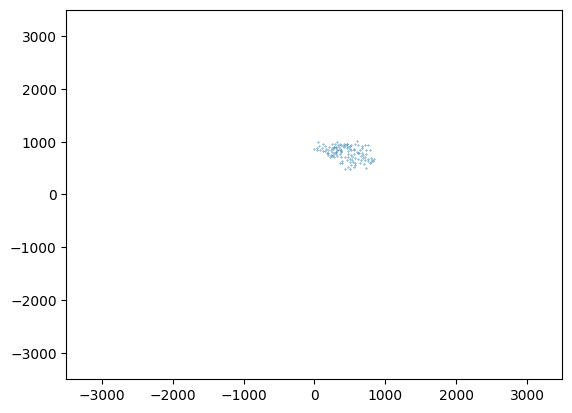

strawman the evidence for vaccination is strong detailed and reproducible evidence against is from blogs etc stopavn
women snub hpv vaccination
blast near vaccination center kills in pakistan s peshawar
would you allow your baby to take part in the ongoing aids vaccination trials
d c conference will discuss developments in vaccine injury compensation vaccination vaccineinjury
paho will pursue cholera vaccination in haiti
great zimbabwe herald op ed calls for water and sanitation improvements to stop typhoid epidemic what about vaccination
i wonder what fallout wakefield s fraud will have on cam i do wish people would stop automatically assuming cam always anti vaccination
i mean seriously don t be like jenny mccarthy and vaccination ge
so you re not prepared to address campaign attitude to contraception and vaccination in public then
canadian pediatricians showed confidence in h n vaccine study indicates via vaccination flu influenza
vaccination and the killers of yesterday now overcom

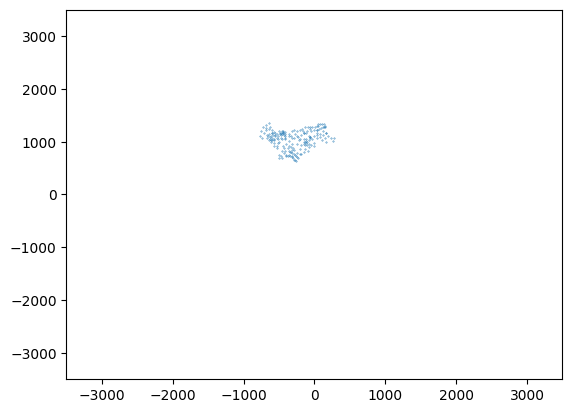

yet more science deadly choices about vaccination
vaccination fears tend to cycle actually usu when vax success makes deadly diseases theoretical but latest cycle yes ugh
citi says flu care card can cut company vaccination costs by vaxfax
got your shots vaccination rates for adults remain low
fast moving african polio outbreak kills spurs vaccination drive
experts to discuss cholera vaccination in the americas
africa vaccination week begins today immunize children protect them from deadly diseases
you ll never publish the truth about vaccination either so what s the big deal
photo tuesday th century smallpox vaccination instruments at history of vaccines scarificator and lancets
we agree our statement alleged fake cia vaccination campaign undermines medical care
katie couric gives the anti vaccination lobby a megaphone
check out robert hickss interesting blog post on spurious smallpox vaccination during the civil war
pox an american history author to speak at coll of physicians of phil

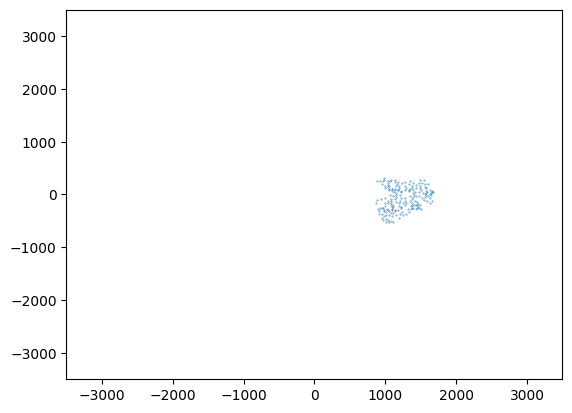

time for a wake up call the vaccination hoax debunked wake up world
nouvelle volution du carnet de vaccination lectronique de mesvaccins net
nine month old twins die just minutes after measles vaccination blacklisted news via depopulation
new limited vaccination strategy based on quantum mechanics via epidemiology physics
new vaccination guidelines include new shots for teens and protection against whoopingcough
avn webinar pertussis vaccination date correction via constantcontact
probiotics enhance effect of vaccination
mobilisation contre la rougeole l occasion de la semaine de la vaccination marseille sante
semaine europenne de la vaccination buzz e sant article via
uk paediatrician and msbp expert knew babies suffered breathing problems and died after vaccination
vietnam halts bird flu vaccination due to new type
vaccination the pet controversy
a study of children showed that use of tylenol after an mmr vaccination increases the risk of autism
tracking down bin laden involved a fak

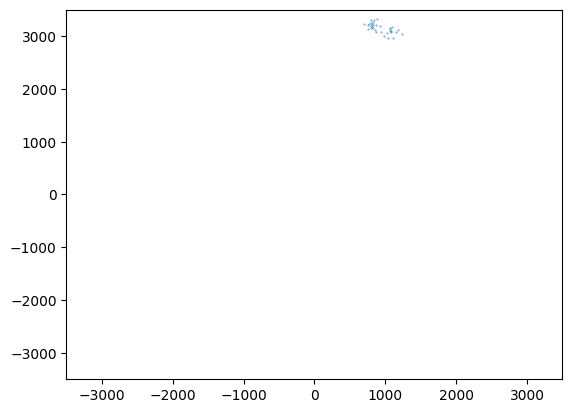

press brief today on flu activity vaccination rates w dr howard koh dr anne schuchat at pm et
next week is national influenza vaccination week nivw
check out pledge page for national influenza vaccination week cdcnivw
its national influenza vaccination week get vaccinated to fight flu via ff nivw
from new influenza vaccination coverage estimates from the march national flu sur influenza flu
saccharum officinale inspiring homeopathy homeopathy vaccination and autism website dr tinus smits
half price vaccination day only in aid of rspcaleaps don t delay book today
were trying to get as many pets as possible protected with our vaccination campaign
halloween is here and that means so is flu season get a free vaccination today learn more at
winter flu vaccination h n and h n is out go get it people
its national influenza vaccination week protect yourself against diabetes flu complications nivw
tomorrow is cosophe s vaccination webinar sign up now publichealth
study by cumedicine shows thous

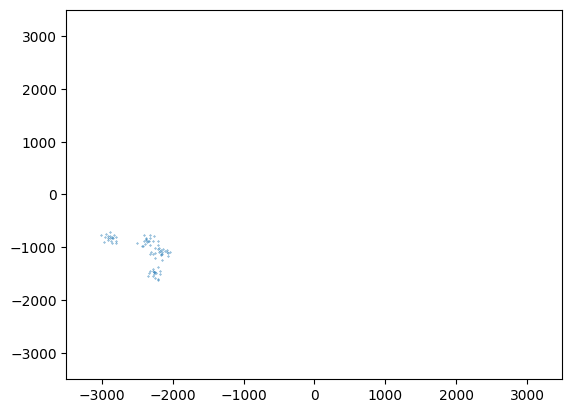

vaccination un calendrier de rappels simplifi chu limoges sante
le septembre l ars aquitaine va vous rveiller vaccination teaser film
som s institute for genome sciences center for vaccine development find gut bacteria play key role in vaccination
check out the latest news on intradermal vaccination
se faire vacciner ctre la grippe rdv pr le avec un mdecin sur sante vaccination
drs mcarthur and pasetti lead workshop on human immune responses against shigella and etec vaccines vaccination
fantastic charity nonprofit work from and measles rubella vaccination globalhealth vaccineswork
rearlvi tiny map their vaccination a carcass her passenger
excellent dossier faire lire aux plus sceptiques sur vaccination contre obscurantisme intellectuel une seule arme ducation pdagogie
golden retriever female puppy for sale vaccination deworming done interested people can
yep a very good friend of mine s husband developed shingles before the vaccination came out and it was the worst pain in his life
fa

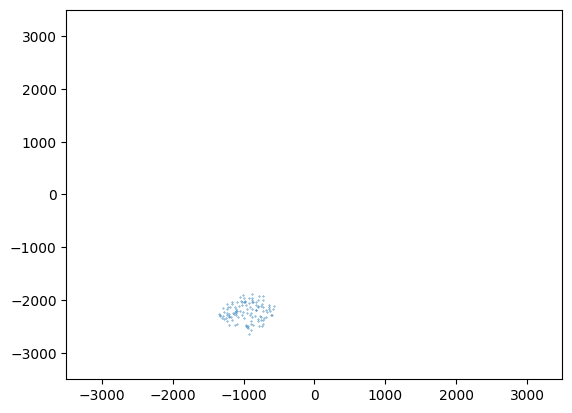

please help us oppose the badger cull we believe vaccination works will vaccinate badgers on our land more here
the vla does the science on badgervaccine with fera is leading wildlifetrusts badger vaccination programme
ambridge votes for a badger vaccination programme research report is mentioned listen again archers
badgercull an interesting piece from the royal society a concluding extract bcg vaccination of badgers could
please help us protect badgers by supporting our vaccination appeal
swt to trail badger vaccination on reserves in the fight against bovine tuberculosis
most common question we keep on being asked is why the reluctance to start a vaccination programme on cont
yesterday i met daphne and natalie to discuss their campaign to improve meningitis vaccination across eu
big congrats uks st independent badger vaccination project proved technique is viable affordable ks
it is bargain bovine tb vaccination for badgers costing only per hectare betterthanacull
badger culling wil

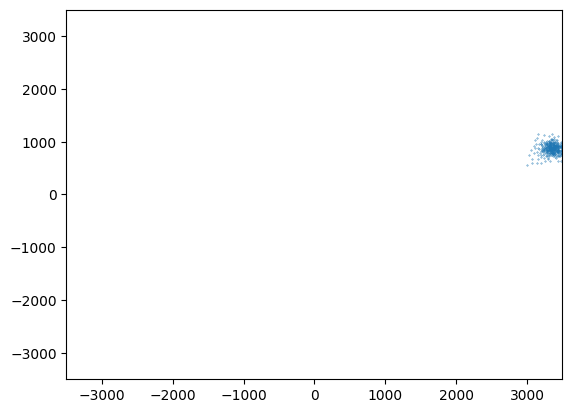

government giving forced vaccination to your kids get vaccine exemption forms
in some states like texas bad vaccination bills have already been prefiled before session even starts
fast moving african polio outbreak kills spurs vaccination drive cnn
women snub hpv vaccination less than a third of women who start out getting the human papillomavirus hpv abc
chiropractors warned to be suspicious in light of avn aust anti vaccination network being investigated
vaccination antigrippe en lgre hausse avec millions de vaccins
history reveals vaccination is bogus
aprs un nouveau cas de mningite c dans le nord l ars lance une grande campagne de sensibilisation la vaccination
how vaccination policy works acip
i liked a youtube video penn point anti vaccination on penn and teller bullshit
check this video out international banksters their vaccination programs pt via
nouvelle campagne de vaccination contre la grippe
vu sur lancement d une campagne pour encourager la vaccination nom
belgian court ru

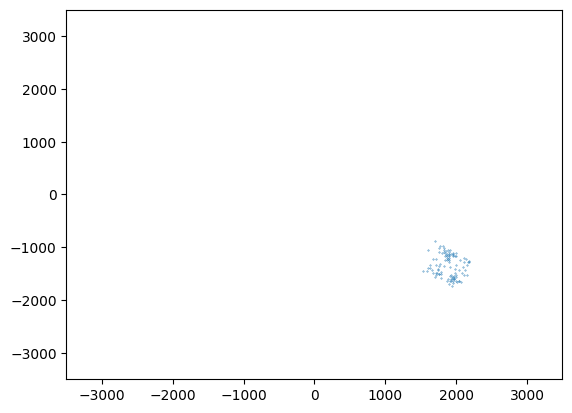

drive for h n vaccination
teamfollowback fast moving african polio outbreak kills spurs vaccination drive world health agen aday
vaccination it works bitches
bill gates register every birth by cellphone to ensure vaccination control population growth
onco cancer a pilot study on the immunogenicity of dendritic cell vaccination during adjuvant oxaliplat colon
do the greens support vaccination qanda
homeopathy instead of vaccination is dangerous nonsense may as well wear a lucky rabbits foot
why do u keep going on about vaccination what has that got to do with anything nothing
blackmailing education with force vaccination is not protection
prophylactic vaccination against human papillomavirus infection and disease in women a systematic review of randomized controlled trials pubmed ncbi
did you hear michele bachmann saying the hpv vaccination is dangerous we re keeping her honest ac
party of fdr passes resolution to support vaccination against childhood disease and protect public health d

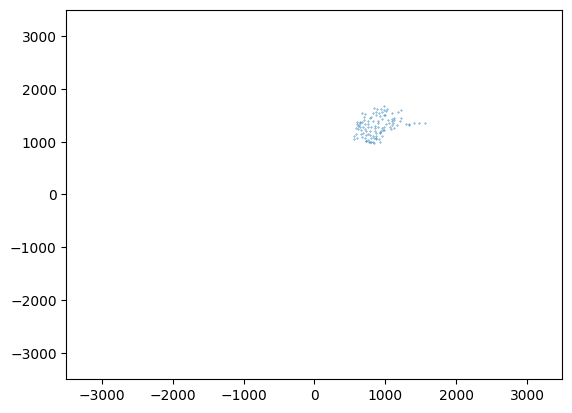

doctors warn medicare co payment could affect vaccination rates via
officials probe britain s first suspected measles death in years after cases blamed on anti vaccination campaign
a reminder of why vaccination campaigns in refugee camps are critically important vaccines
visit our flickr set to see all of the photos from today s polio vaccination in guinea
a photographic account of the difficult conditions facing msf s measles vaccination programme in drc
social mobilization is important for vaccination campaigns but one should not forget sronger advocacy and
trs heureuse de participer sommetmada avec o nous avons conclu notre partenariat pour la vaccination
vaccine report international medical council on vaccination global conspiracy theories via
i ve taken the vaccination pledge have you
aussie boys need hpv vaccination experts
hunting studies exploring vaccination rates and culture belief migration issues eg any thoughts
thanks for retweeting let s continue the conversation around v

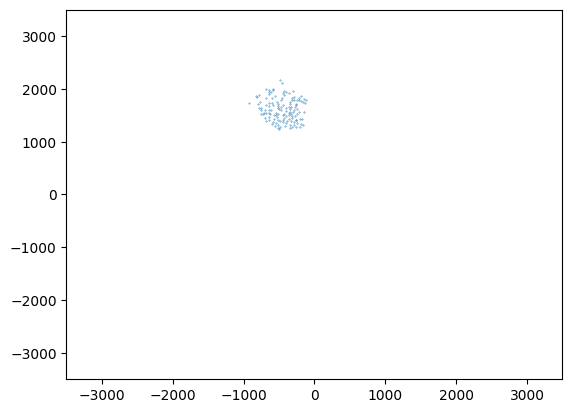

flutrackers seasonal influenza vaccination policy consult your medical practitioner
japan anaphylactic shock from vaccination flutrackers
citi says flu care card can cut company vaccination costs by vaxfax
gov brown has signed a bill making it harder for parents to get vaccination exemptions for kids
discussion about vaccination efficiency has been added to the medscape reference topic mumps at
million central africans targeted for massive polio vaccination campaign healthnews
i guess the fact that she allows her foaming at the mouth attitudes towards vaccination homosexuality arabs co etc to
flu vaccination disparities exacerbated by supply problems
have you received your flu shot this year take the cdc s flu ends with u vaccination pledge here
kids going into grades need a pertussis vaccination please retweet to your friends who have teens
now breaks down the effects and long term impact of sb or as some call it the vaccination law
just in time for national influenza vaccination week

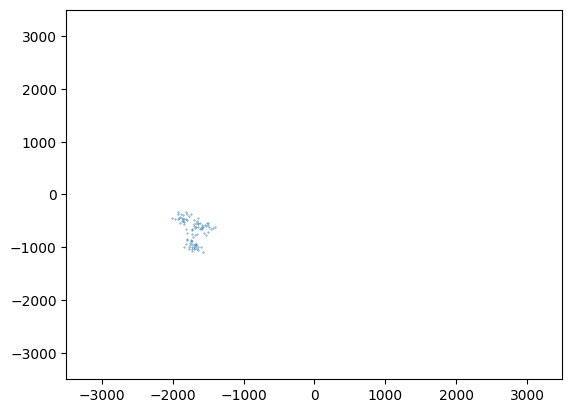

us haiti launch vaccination campaigns to curb or keep out infectious diseases vw
jerrybrown pro vaccination pro big pharma
public health officials worried about outbreaks in pockets of the country where vaccination rates are dangerously low
it took me hrs birth certificate childhood vaccination certificate voter registration get photo id i m an election judge
ashland or still has one of the lowest vaccination rates in the country vaccinewar
chili s cancels autism fundraiser over organization s vaccination comments
current gov t approval for vaccination of boys will continue to reduce spread of hpv it s consequences
adult vaccination rates unacceptably low say u s health authorities
university of bc doctors expose vaccination cover up read all about it here
he personally went to bihar and has started vaccination program immediately
in wealthy l a schools vaccination rates are as low as south sudan s
please also due for damages from shedding spreading virus from vaccination process
for t

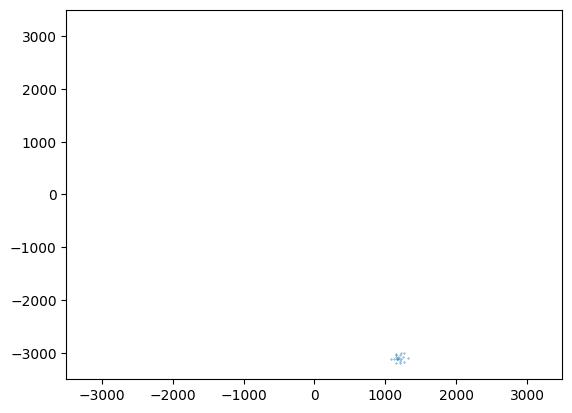

somalia mass vaccination campaign against deadly childhood diseases launched in puntland
i just had vaccination for a nasty disease i never had and don t want to have ouch muscle aches procrastination makes it worse
in the national vaccination program we were reaching almost coverage
i know a few folks who need that vaccination right now no need to mention names lol
i am with you on the options regarding influenza vaccinations i am just aghast at the lack of care for others exhibited in vaccination behavior s my mother and father remembered the fall out of the spanish flu my mom recounted stories of hydration with coca cola syrup
do you have any idea why these guys don t support vaccination it isn t about autism it is about natural immunity
NUMBER OF TWEETS: 22
NUMBER OF CONVERSATIONS 14

Cluster 34



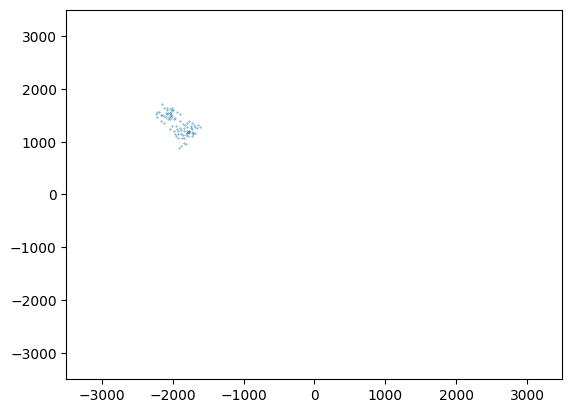

nation wants hpv vaccination for boys
prof margaret stanley s letter to scottish parliament adocating hpv vaccination for boys clear and definitive
its december and winter is here but it s not too late to get your flu vaccination to help stop flu spreading
nation wants hpv vaccination for boys
ditching flu vaccination campaign has put under fives at risk labour is demanding a rethink after the governm
please sign the counting the cost petition to the uk government supporting meningitis vaccination
seasonal flu vaccination who should have it and why
genital warts vaccination to be offered to schoolgirls
should hpv vaccination now be extended to boys prof henry kitchener thinks so
new twist to me issue many of these teenage girls have been diagnosed with me following hpv vaccination
was a great day when parliament protected badgers now we have this nonsense of shooting them deal with btb by vaccination not destruction
extend the hpv vaccination process to boys nurses say no need says dh 

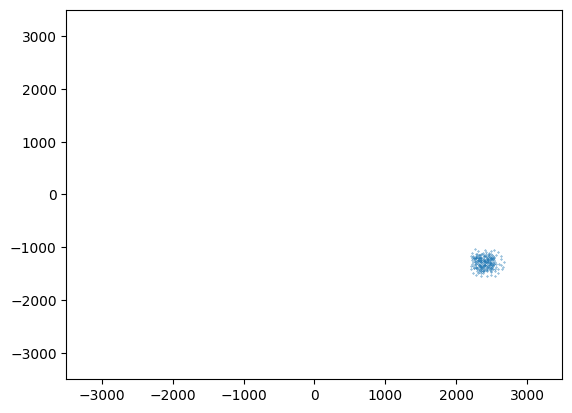

sitfu com russian activist disappears after exposing vaccination plans for russia ukraine and belarus alexan
flu vaccination programme for pregnant women underway
flu vaccination event raises more than k for charity that benefits needy
vaccination dangers health
the sharp end of vaccination gets served the case for vax is made brutally clear stopavn skeptics
i can t see a story like this appearing in australia our media would never report the truth about vaccination
gardasil hpv vaccine stopping genital warts in australia widespread vaccination of girls with the gard health
gardasil hpv vaccine stopping genital warts in australia widespread vaccination of girls with the gardasil hpv
russian activist disappears after exposing vaccination plans for russia ukraine and belarus infowars ireland
cervical cancer risk to women despite vaccination possibilty research from england reveals that cervical c
low cost rabies vaccination clinic offered
nprhealth health experts cholera vaccination in h

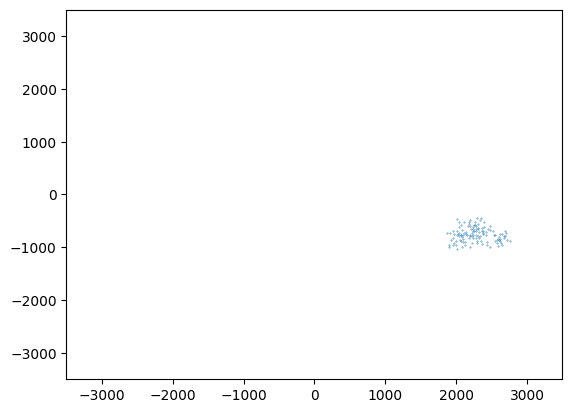

vaccine epidemic by louise kuo habakus and mary holland australian vaccination network via
doh launches rotavirus vaccination and catastrophic benefit package press release july children need not
malawakang vaccination sa mga lugar na naapektuhan ng bagyong yolandaph sinimulan na ng who at doh
today is start of nationwide abscbn oras door to door measles vaccination for children born between may and july
i know the plights of the parents sometimes compromizing rheie childs vaccination bec of lack of funds
still admits increased risks and far from flying off the handle this revelation should ensure that if the dengue vaccination program is to be continued it must come with prescreening which lowers the risks
hum never got flu shots also if you had chicken pox as a kid you don t need a vaccination if not you should get a shot
california eliminates informed parental consent knowledge for kids vaccination
no excuse for skipping anti rabies vaccination in makati
flu vaccination here we come

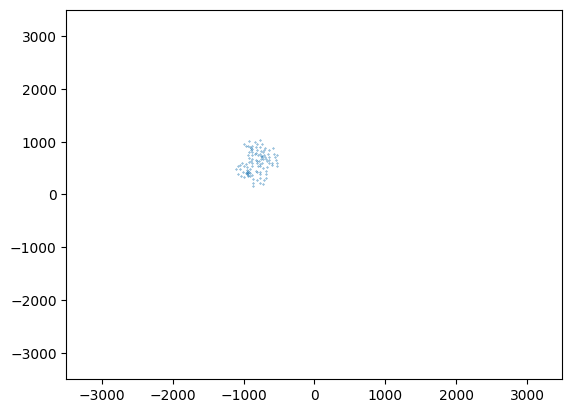

must read breaking international medical council on vaccination refutes vaccine propaganda with myth busting report
dept releases info on yellow fever vaccination requirements and shortage of vaccine
great stuff many hospitals now have a hepb vaccination programme for newborns at risk due to maternal hepb hepc
the polio victims on the iron lungs that s not post vaccination i don t think the other pic i don t recognise
wondering about herpes zoster vaccination to prevent shingles in older adults new cochraneevidence see our feature
arranging home visits specifically for influenza vaccination in over s is effective in increasing uptake
ama nsw welcomes government order for australian vaccination network to change its name
cnn writes story about syria n govt polio vaccination campaign but imbed video of latest baby in incubator story
flu vaccines are available from gps aboriginal health services and community vaccination providers
you misunderstood the findings from that study the finish 

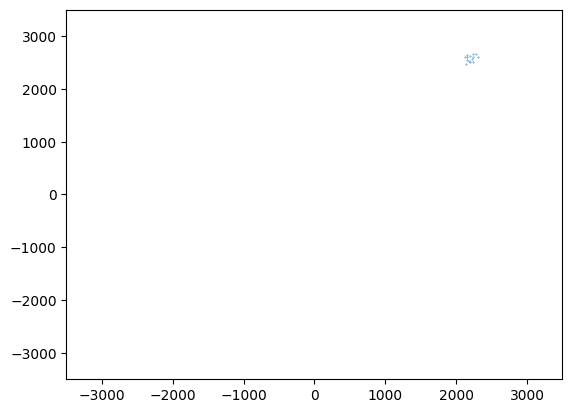

govt s mr vaccination programme protects your child from measles rubella your participation is important let us fight together
mr kumar manish is speaking on effective use of social media for mr vaccination mrvaccination
media deviating attention gorakhpurtragedy right time to speak on need of vaccination and fight vpd among children support vaccination
stress vaccination course this course teach u how can u fight with stress no age issue any one cn take this course
vaccination is d only protection from polio lets endpolio now forever
NUMBER OF TWEETS: 192
NUMBER OF CONVERSATIONS 75

Cluster 39



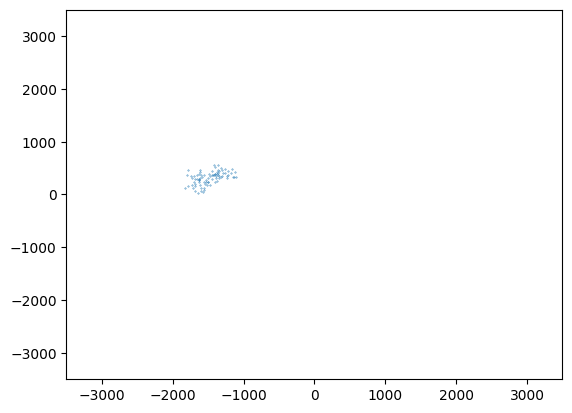

i m filming a dvd about the hpv vaccination today currently in burntwood secondary school talking to pupils about the jab
million for polio vaccination in districts kisumu
intensive polio vaccination campaign on going and will end on july avail children below years to nearest government health facility
prophetess accepts polio vaccination for children
choose between brands of vaccines with the npas flu vaccination pgd
dr sturgis sets the record straight on hpv vaccination against cancers in men hpv cancer
so lets get this straight vaccination rate and youre blaming measles on one paper written years ago meanwhile autism rate has increased from in to in in that time and you could care less
incao s hepatitis b vaccination testimony in ohio
kenyan school going girls to receive free cervical cancer vaccination
vaccination teams will be moving from house to house immunizing children poliovaccinationcampaign
dr wakefield speaks puts critics forced vaccination to rest
business case for flu va

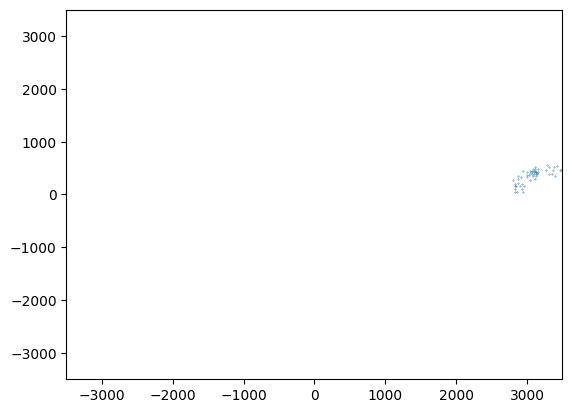

msf begins cholera vaccination campaign in zambia s capital
curb typhoid epidemic through vaccination
google searches for chickenpox reveal big impact of vaccination infection control today
worst case of chickenpox sparks call for vaccination rethink cancer beatcancer
worst case of chickenpox sparks call for vaccination rethink cancer beatcancer
vaccination ranrou les relais saluent ladhsion despopulations
guess which child was given a smallpox vaccination
aus government launches new campaign promoting vaccination despite more evidence of vaccines damaging our children why
yeah i think the men b vaccination gave her a pretty bad fever she seems happy enough at the moment though
NUMBER OF TWEETS: 829
NUMBER OF CONVERSATIONS 223

Cluster 41



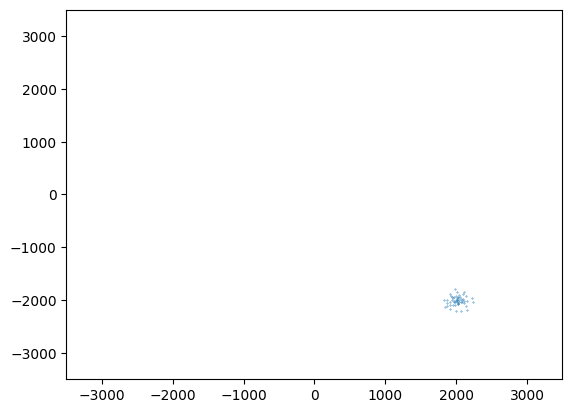

male circumcision is a minor surgical vaccination against numerous fatal illnesses other than that you re on
vaccination has saved millions of children s lives polio whooping cough diphtheria dangerousnonsense
let us hope these brave workers will have multiple followers if not we may have to in the future proving vaccination to enter an airplane bus train or or government buildings
NUMBER OF TWEETS: 25
NUMBER OF CONVERSATIONS 10

Cluster 42



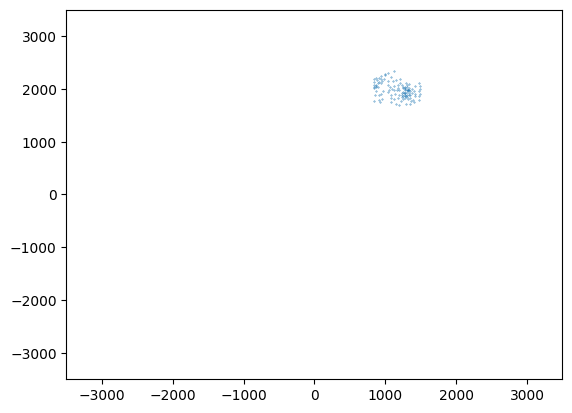

fighting the flu one vaccine at a time san francisco chronicle blog vaccination sf
global routine vaccination coverage
news strengthening routine flu vaccination and health programs may improve pandemic vaccine coverage
racial ethnic disparities in childhood flu vaccination coverage have improved over the past decade
take the pledge to support school based flu vaccination nasnflushot
from flu vaccination in school kids helps protect everyone it s so true
order free posters promoting no and low cost vaccination through vaccines for children vfc
reports vaccination rates for adults
cdc vaccination rates low in us adults
the importance of encouraging adult vaccination this fall via
estimates of adult vaccination coverage for hepatitis a and hepatitis b are now online mmwr
recommending sti vaccination to parents of adolescents attitudes of nurse practitioners
new bmcpublichealth article discusses influential factors in hpv vaccination uptake cancer
a look at missed opportunities for vaccin

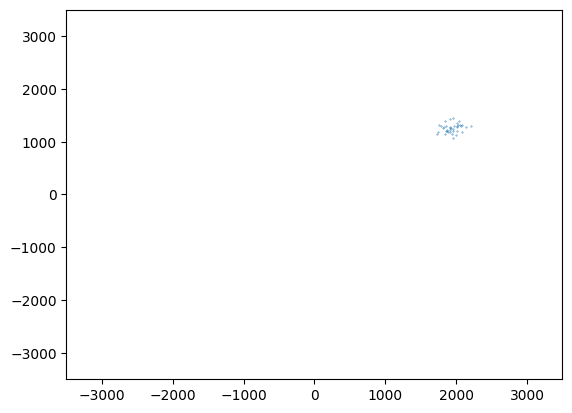

families in yemen welcome nationwide vaccination campaign vaccineswork
flu vaccination may lower the risk of hospital admission in patients with type diabetes according to a new study
don t worry anymore about rabid animals just get a rabies vaccination which i made for you in afhshtr afhshtr
the large turnout of people csm vaccination in gada lga of sokoto is impressive
targeted for vaccination in two lgas via
NUMBER OF TWEETS: 643
NUMBER OF CONVERSATIONS 201

Cluster 44



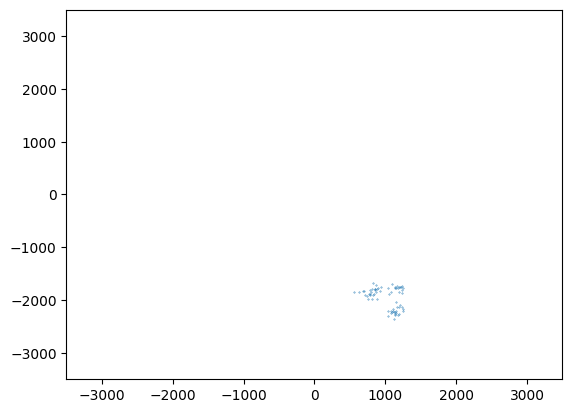

evaluation of cost effective strategies for rabies post exposure vaccination in low income countries
radiation vaccination like i suggested man i should joke more often
turkish health minister slams top court ruling on vaccination without parental consent to be unconstiti via
tetanus diphtheria and pertussis tdap vaccination every years is unnecessary a new cross sectional analysi
non a la vaccination obligatoire mme la ministre de la sante buzyn nous ment pour enrichir les lobbies
hpv vaccination more effective than thought via
even though people thought that using killed strains of polio as a vaccination was crazy i decided to just do it dontletdreamsbedreams
busy day with flu vaccination in women s health yesterday divisional manager leading the way against man flu
NUMBER OF TWEETS: 1134
NUMBER OF CONVERSATIONS 277

Cluster 45



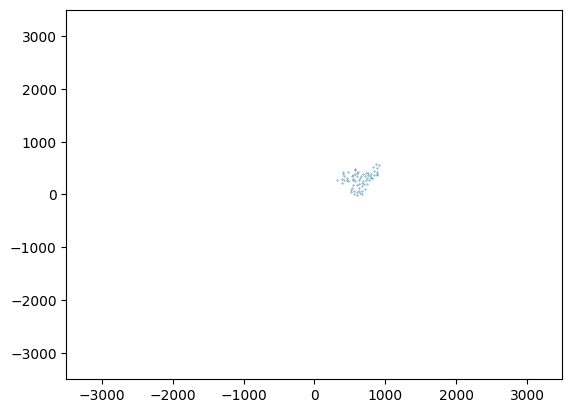

family sues after teen dies following hpv vaccination canada news toronto sun
youtube school vaccination policy part two
by raising legitimate questions about vaccination cpr seeks to make warriors voices heard
naturalnews exclusive intnl med council on vaccination refutes vax propaganda in myth busting report via
vaccination fears not as crazy as you may think by bob moffitt
prior to vaccination hib affected as many as children and caused serious reactions of those death in
ok so i would like to know how about the diseases we can t heal but we can avod by vaccination i m not for vaccination
stop a dutch genetically engineered gm vaccination study in foals from days old untill months via
stop a dutch genetically engineered gm vaccination study in foals from days old untill months via
stop a dutch genetically engineered gm vaccination study in foals from days old untill months via
stop a dutch genetically engineered gm vaccination study in foals from days old untill months via
chechi is

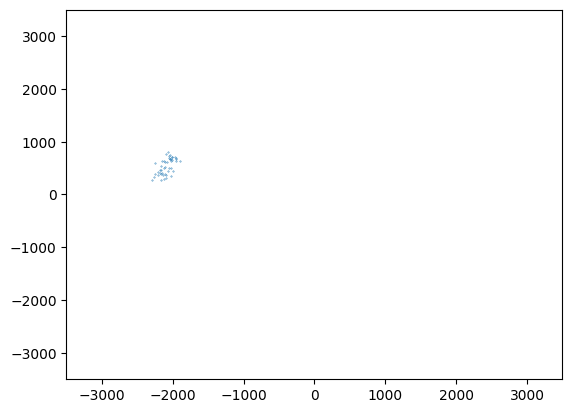

imogen richards talks about her research focusing on perceptions of dairy farmers to vaccination strategies phdseminar
thanks to all who contributed to a great day with vet practitioners and academics discussing vaccination strategies in cattle
great day with our expert discussion forum ndhhg discussing issues around vaccination in cattle and there s more than you d think
if you have diabetes then protect yourself and get your seasonal flu vaccination as soon as possible flusafe
lol you seriously need tarkk vaccination d
unicef is looking for more focus on children in the euro resolutions try to improve vaccination education amwho
NUMBER OF TWEETS: 610
NUMBER OF CONVERSATIONS 223

Cluster 47



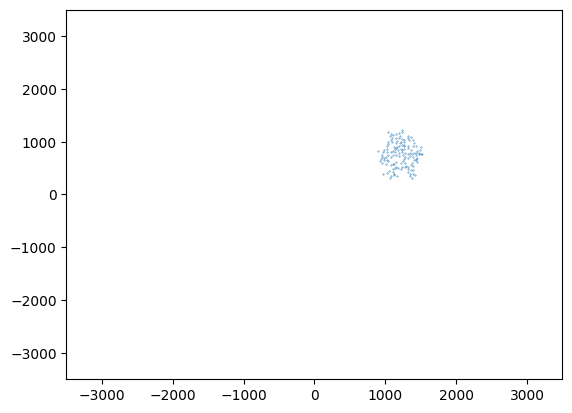

winning is the way to go honcode flushes some anti vaccination liars
quadrivalent human papillomavirus vaccination and trends in genital warts in australia
afghan taliban support polio vaccination campaign cnn
hajj fct begins vaccination of intending pilgrims
my op ed for the giardian polio in ukraine vaccination campaign needs to start straight away stoppolio
campagne de vaccination contre la mningite au burkina faso
who african vaccination week clashes with april polls but nphcda responds by rescheduling dates for nigeria
arrangements are underway to commence a pilot of supported demonstration on hpv vaccination in some selected states in nigeria
n bn earmarked for meningitis vaccination in sokoto
is vaccination against human papilloma virus a cost effective intervention
from using repostregramapp measles vaccination campaign commences today
how u fit prevent pneumonia exclusive breastfeeding regular hand washing with soap water eliminate household pollution vaccination
cervicalcance

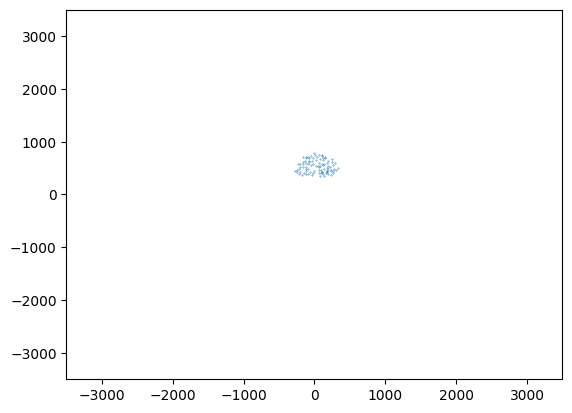

health experts cholera vaccination in haiti not possible until spring
be heard hhs conscience religious freedom division wants your input on vaccination policy via
just trying to increase vaccination rates to protect kids and public health happy to discuss
u dont have tell shrunk down to volunteer us mil wearied w repeat tdys ptsd vaccination damage abandonment home fine w me
i m looking for information on vaccination for babies and children
oh more anti vaccination paranoia
south africa deports nigerians over yellow fever vaccination this day
hpv infection can lead to cervicalcancer see what the nationalimmunisationadvisorycommittee says about vaccination
boots are offering the winter flu vaccination free to medical card holders at risk groups cancer patients and carers
bhasha singh of we need to write stories on vaccination that focus on migrant population
have a walk around an old cemetery first see how many of the graves were for children before vaccination
main show only vaccinati

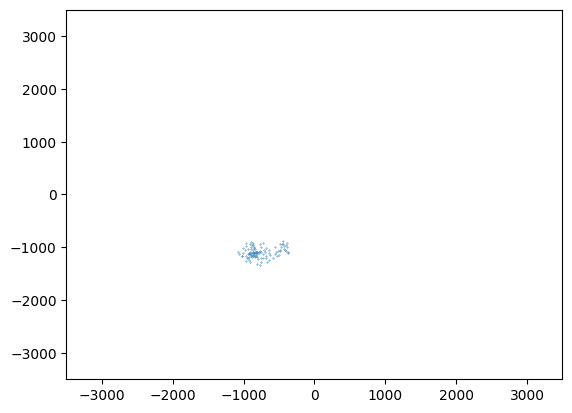

vaccination rates fall among better educated families even while cdc keeps pushing vaccine
vaccination rates fall among better educated families even while cdc keeps pushing vaccine quackery via
homeopathy safe medicine a healthy child vaccination a damaged child hom
bill gates register every birth by cellphone to ensure vaccination control population growth
bill gates register every birth by cellphone to ensure vaccination control population growth
vaccination rates fall among better educated families even while cdc keeps pushing vaccine quackery via
flu vaccination rates up especially among kids
excellent article and worth a read debating vaccination by dr brian martin via constantcontact
nine month old twins die just minutes after measles vaccination via
novax vaccination video lethal medical failure still recommended by your doctor
international medical council on vaccination refutes vaccine propaganda with myth busting report
italian vaccine awareness group confronts who pandemic 

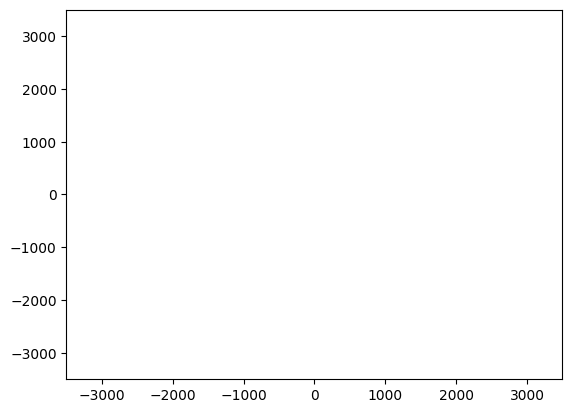

NUMBER OF TWEETS: 0
NUMBER OF CONVERSATIONS 0



In [96]:
for cluster in range(1, 51):
    modul_dotes = dotes.query('cluster == @cluster')
    print(f'Cluster {cluster}')
    print()
    plt.xlim(-3500, 3500)
    plt.ylim(-3500, 3500)
    plt.scatter(modul_dotes['X'], modul_dotes['Y'], s=0.1, label=cluster)
    plt.show()

    number_of_tweets = 0
    conversations = set()

    for user_id in modul_dotes['Id']:
        try:
            tweets = df_replies.query('user_id == @user_id')
            conversations |= set(tweets['conversation_id'])
            number_of_tweets += len(tweets)
            print(tweets['cleaned_tweet'].iloc[0])
        except:
            pass
    print(f'NUMBER OF TWEETS: {number_of_tweets}')
    print(f'NUMBER OF CONVERSATIONS {len(conversations)}')
    print()

### Кластеры-сообщества
- **Кластер 21** (-500, 2500):
    The common theme among these texts is vaccination campaigns and their importance in preventing diseases. The texts mention specific vaccination campaigns being carried out in various countries to prevent diseases like yellow fever, meningitis, polio, and measles. They also mention the global vaccination campaign against pneumonia and the BCG vaccination policy. Finally, one text references anti-vaxxers as a negative force that opposes vaccination efforts.
    *NUMBER OF TWEETS*: 6143
    *NUMBER OF CONVERSATIONS* 842

- **Кластер 18** (0, 2500):
    The common theme among these texts is vaccination and the surrounding issues related to vaccination. The texts include discussions of the importance of vaccination, the dangers of not vaccinating, controversies surrounding vaccination, the effectiveness of vaccination, the ethics of vaccination, and the impact of vaccination on public health. They also mention specific diseases that can be prevented by vaccination, such as Hib epiglottitis, measles, and yellow fever. Some texts discuss the debate over compulsory vaccination, while others address the challenges of communicating the benefits of vaccination to the public.
        *NUMBER OF TWEETS*: 17028
        *NUMBER OF CONVERSATIONS* 1141
- **Кластер 19** (-300, 100):
    The common theme among these texts is the controversy surrounding vaccination. The texts include discussions of the potential risks and benefits of vaccination, the effectiveness of vaccines, concerns about vaccine safety, and debates about mandatory vaccination policies. Some texts criticize those who are against vaccination, while others question the efficacy of certain vaccines or express concerns about the long-term effects of vaccination. Additionally, some texts mention specific diseases or vaccines, such as HPV or chickenpox, and others address the use of vaccines to prevent the spread of infectious diseases, such as influenza or polio.
    *NUMBER OF TWEETS*: 6637
    *NUMBER OF CONVERSATIONS* 708
- **Кластер 6** (0, -3000):
    The common theme between the texts is badger vaccination and its impact on bovine TB. Some texts express support for badger vaccination as a solution to the spread of bovine TB, while others express skepticism about its effectiveness or preference for culling badgers instead. Some texts also discuss the challenges of implementing badger vaccination programs and the need for more investment in research.
    *NUMBER OF TWEETS*: 6358
    *NUMBER OF CONVERSATIONS* 730
- **Кластер 35** (2500, -500):
    forced vaccination, vaccine exemption forms, bad vaccination bills, polio outbreak, HPV vaccination, anti-vaccination network, Penn and Teller Bullshit, international banksters, excessive vaccination, Bill Gates, kids died after vaccination, autism-vaccination link, new vaccination guidelines, secret vaccination, police helps vaccination, meningitis, pandemic influenza infection and vaccination
        *NUMBER OF TWEETS*: 6173
        *NUMBER OF CONVERSATIONS* 1365

- **Кластер 28** (3500, 500):
    government, forced vaccination, kids, vaccine exemption forms, texas, vaccination bills, polio outbreak, african, women, hpv vaccination, human papillomavirus, chiropractors, avn aust anti vaccination network
    NUMBER OF TWEETS: 8961
    NUMBER OF CONVERSATIONS 877

In [52]:
graph_statistics

,Id,Label,modularity_class,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,stat_inf_class,clustering,componentnumber,strongcompnum,indegree,outdegree,degree,pageranks,eigencentrality,X,Y,Size,Color
0,19471256,19471256,0,0,0.000000,0.000000,0.00,0,0.000000,0,0,1,1,2,0.000003,0.000543,4474.727051,5673.375000,10,#000000
1,22371039,22371039,1,0,0.000000,0.000000,0.00,1,0.000000,1,1,1,1,2,0.000003,0.000543,7253.721191,275.154907,10,#000000
2,131188226,131188226,2,0,0.000000,0.000000,0.00,2,0.000000,2,2,1,1,2,0.000003,0.000543,7865.322754,-5738.039551,10,#000000
3,14270356,14270356,3,0,0.000000,0.000000,0.00,3,0.000000,3,3,1,1,2,0.000003,0.000543,5429.376953,6731.066406,10,#000000
4,112724522,112724522,848,2,0.758621,0.840909,5364.45,37564,0.050725,4,26,9,16,25,0.000011,0.038338,613.029541,-157.643845,10,#000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57035,881218243,881218243,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,56769,1,0,1,0.000003,0.000543,1881.251343,-1593.412109,10,#000000
57036,950464698880876544,950464698880876544,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,56768,1,0,1,0.000003,0.000543,1864.592896,-1634.596069,10,#000000
57037,986041419067408385,986041419067408385,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,56767,1,0,1,0.000003,0.000543,1924.354004,-1594.196533,10,#000000
57038,2189944839,2189944839,4341,2,0.800000,0.875000,0.00,37564,0.250000,4,56790,1,4,5,0.000003,0.000543,-1740.692627,563.545959,10,#000000


In [95]:
dotes

,Id,Label,modularity_class,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,stat_inf_class,clustering,componentnumber,...,indegree,outdegree,degree,pageranks,eigencentrality,X,Y,Size,Color,cluster
4,112724522,112724522,848,2,0.758621,0.840909,5364.45,37564,0.050725,4,...,9,16,25,0.000011,0.038338,613.029541,-157.643845,10,#000000,2
5,16426177,16426177,848,0,0.000000,0.000000,0.00,37564,0.500000,4,...,2,1,3,0.000004,0.009842,614.886047,-158.641068,10,#000000,2
6,262724663,262724663,848,0,0.000000,0.000000,0.00,37564,0.500000,4,...,3,1,4,0.000004,0.010677,593.963867,-292.862122,10,#000000,2
7,22931893,22931893,848,0,0.000000,0.000000,0.00,37564,0.333333,4,...,4,1,5,0.000004,0.045608,634.482971,-81.524704,10,#000000,2
8,34115195,34115195,8043,0,0.000000,0.000000,0.00,37564,0.089286,4,...,8,0,8,0.000009,0.097574,277.517944,2074.891602,10,#000000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57035,881218243,881218243,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,...,1,0,1,0.000003,0.000543,1881.251343,-1593.412109,10,#000000,29
57036,950464698880876544,950464698880876544,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,...,1,0,1,0.000003,0.000543,1864.592896,-1634.596069,10,#000000,29
57037,986041419067408385,986041419067408385,3456,0,0.000000,0.000000,0.00,37564,0.000000,4,...,1,0,1,0.000003,0.000543,1924.354004,-1594.196533,10,#000000,29
57038,2189944839,2189944839,4341,2,0.800000,0.875000,0.00,37564,0.250000,4,...,1,4,5,0.000003,0.000543,-1740.692627,563.545959,10,#000000,8
